In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import random
import re
from numba import njit
from lxml import etree

plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 22
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

/tmp/ipykernel_290164/2081392314.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-deep')


# Downloaded from https://github.com/unicode-org/cldr/tree/main

In [2]:
xml_file = "/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/supplementalData.xml"
tree = etree.parse(xml_file)

# 1. Extract Territory Data
territories = []
countries = []
populations = []
languages_list = []

for territory in tree.xpath("//territory"):
    territory_type = territory.get("type")
    population = int(territory.get("population"))
    country_name = territory.xpath("string(comment())").strip()

    languages = []
    for lang in territory.xpath(".//languagePopulation"):
        lang_type = lang.get("type")
        population_percent = float(lang.get("populationPercent"))
        lang_name = lang.xpath("string(comment())").strip()
        languages.append([lang_type, population_percent])

    if population > 0:
        territories.append(territory_type)
        countries.append(country_name)
        populations.append(population)
        languages_list.append(languages)

territory_df = pd.DataFrame({
    "Territory": territories,
    "Name": countries,
    "Population": populations,
    "Languages": languages_list
})

territory_df

,Territory,Name,Population,Languages
0,AC,Ascension Island,940,"[[en, 99.0]]"
1,AD,Andorra,85370,"[[ca, 51.0], [es, 43.0], [fr, 6.8]]"
2,AE,United Arab Emirates,10032200,"[[ar, 78.0], [en, 50.0], [ml, 7.0], [ps, 2.9],..."
3,AF,Afghanistan,40121600,"[[fa, 50.0], [ps, 43.0], [haz, 5.9], [uz_Arab,..."
4,AG,Antigua & Barbuda,102634,"[[en, 86.0], [pt, 1.6]]"
...,...,...,...,...
252,YE,Yemen,32140400,"[[ar, 74.0], [en, 9.0]]"
253,YT,Mayotte,194000,"[[swb, 88.0], [fr, 63.0], [buc, 23.0], [sw, 1.4]]"
254,ZA,South Africa,60442600,"[[en, 31.0], [zu, 24.0], [xh, 18.0], [af, 13.0..."
255,ZM,Zambia,20799100,"[[bem, 31.0], [en, 16.0], [ny, 15.0], [loz, 6.0]]"


In [3]:
country_codes = pd.read_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/country_codes.csv")

df_countries = pd.merge(territory_df, country_codes, left_on='Territory', right_on='alpha-2', how='inner')
df_countries.head()

,Territory,Name,Population,Languages,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,AD,Andorra,85370,"[[ca, 51.0], [es, 43.0], [fr, 6.8]]",Andorra,AD,AND,20,ISO 3166-2:AD,Europe,Southern Europe,NaN,150.0,39.0,NaN
1,AE,United Arab Emirates,10032200,"[[ar, 78.0], [en, 50.0], [ml, 7.0], [ps, 2.9],...",United Arab Emirates,AE,ARE,784,ISO 3166-2:AE,Asia,Western Asia,NaN,142.0,145.0,NaN
2,AF,Afghanistan,40121600,"[[fa, 50.0], [ps, 43.0], [haz, 5.9], [uz_Arab,...",Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
3,AG,Antigua & Barbuda,102634,"[[en, 86.0], [pt, 1.6]]",Antigua and Barbuda,AG,ATG,28,ISO 3166-2:AG,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0
4,AI,Anguilla,19416,"[[en, 95.0]]",Anguilla,AI,AIA,660,ISO 3166-2:AI,Americas,Latin America and the Caribbean,Caribbean,19.0,419.0,29.0


In [4]:
# df_countries.to_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/df_countries.csv",
#                    index=False)

In [5]:
language_types = []
language_names = []

for lang in tree.xpath("//languagePopulation"):
    lang_type = lang.get("type")
    comment_nodes = lang.xpath("following-sibling::comment()[1]")
    lang_name = comment_nodes[0].text.strip() if comment_nodes else ""
    language_types.append(lang_type)
    language_names.append(lang_name)

languages_df = pd.DataFrame({
    "Language Type": language_types,
    "Language Name": language_names
})

# 3. Extract Scripts Data from <languageData>
language_types_ld = []
scripts_list = []

for lang in tree.xpath("//languageData/language"):
    lang_type = lang.get("type")
    scripts = lang.get("scripts", "")
    language_types_ld.append(lang_type)
    scripts_list.append(scripts)

language_scripts_df = pd.DataFrame({
    "Language Type": language_types_ld,
    "Scripts": scripts_list
})

merged_languages_df = pd.merge(languages_df, language_scripts_df, on="Language Type", how="left")

cleaned_languages_df = merged_languages_df.drop_duplicates(subset=["Language Type", "Language Name"])
cleaned_languages_df

,Language Type,Language Name,Scripts
0,en,English,Latn
2,ca,Catalan,Latn
4,es,Spanish,Latn
6,fr,French,Latn
8,ar,Arabic,Arab
...,...,...,...
2476,loz,Lozi,Latn
2478,sn,Shona,Latn
2481,nd,North Ndebele,Latn
2482,mxc,Manyika,Latn


In [6]:
cleaned_languages_df[cleaned_languages_df['Language Type'] == 'zh']

,Language Type,Language Name,Scripts
249,zh,Chinese,Hans Hant


In [7]:
expanded_languages_df = cleaned_languages_df.copy()

# Initialize lists for expanded data
expanded_language_types = []
expanded_language_names = []
expanded_scripts = []

# Iterate through each row and split scripts if necessary
for _, row in expanded_languages_df.iterrows():
    language_type = row["Language Type"]
    language_name = row["Language Name"]
    if isinstance(row['Scripts'], float):
        row["Scripts"] = "NaN"
        
    scripts = row["Scripts"].split()  # Split by spaces

    if len(scripts) > 1:
        for script in scripts:
            expanded_language_types.append(f"{language_type}_{script}")
            expanded_language_names.append(language_name)
            expanded_scripts.append(script)
    else:
        # Keep the original entry if there's only one script
        expanded_language_types.append(language_type)
        expanded_language_names.append(language_name)
        expanded_scripts.append(scripts[0] if scripts else "")
        
# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    "Language Type": expanded_language_types,
    "Language Name": expanded_language_names,
    "Scripts": expanded_scripts
})

expanded_df

,Language Type,Language Name,Scripts
0,en,English,Latn
1,ca,Catalan,Latn
2,es,Spanish,Latn
3,fr,French,Latn
4,ar,Arabic,Arab
...,...,...,...
766,loz,Lozi,Latn
767,sn,Shona,Latn
768,nd,North Ndebele,Latn
769,mxc,Manyika,Latn


In [8]:
expanded_df[expanded_df['Language Type'] == 'zh']

,Language Type,Language Name,Scripts


In [93]:
# expanded_df.to_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/language_scripts.csv",
#                   index=False)

In [9]:
# cleaned_languages_df.to_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/language_scripts_cleaned.csv",
#                   index=False)

In [83]:
cleaned_languages_df[cleaned_languages_df['Language Type'] == 'zh']

,Language Type,Language Name,Scripts
249,zh,Chinese,Hans Hant


In [59]:
df_countries[df_countries['Territory'] == 'AF']['Languages'].values

array([list([['fa', 50.0], ['ps', 43.0], ['haz', 5.9], ['uz_Arab', 4.7], ['tk', 1.7], ['prd', 1.2], ['bgn', 0.63], ['kaa', 0.0084], ['ug', 0.0075], ['kk_Arab', 0.005]])],
      dtype=object)

In [60]:
territory_list = []
language_list = []

for index, row in df_countries.iterrows():
    territory = row["Territory"]
    languages = row["Languages"]
    
    for lang_entry in languages:
        lang_type = lang_entry[0]
        territory_list.append(territory)
        language_list.append(lang_type)

bipartite_edgelist_df = pd.DataFrame({
    "Territory": territory_list,
    "Language": language_list
})
bipartite_edgelist_df

,Territory,Language
0,AD,ca
1,AD,es
2,AD,fr
3,AE,ar
4,AE,en
...,...,...
1484,ZW,ndc
1485,ZW,kck
1486,ZW,ny
1487,ZW,ve


In [74]:
# bipartite_edgelist_df.to_csv("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/country_lang.txt", 
#                              sep=" ", index=False, header=None)

In [75]:
from networkx.algorithms import bipartite


g = bipartite.read_edgelist("/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/country_lang.txt")

print(g)

Graph with 966 nodes and 1489 edges


In [76]:
largest_cc = max(nx.connected_components(g), key=len)
GCC = g.subgraph(largest_cc).copy()
print(GCC)

Graph with 963 nodes and 1487 edges


In [100]:
nodesA, nodesB = 0, 0
for n in GCC.nodes(data=True):
    if n[1]['bipartite'] == 0:
        nodesA += 1
    else:
        nodesB += 1
        
nodesA, nodesB, nodesA + nodesB

(246, 717, 963)

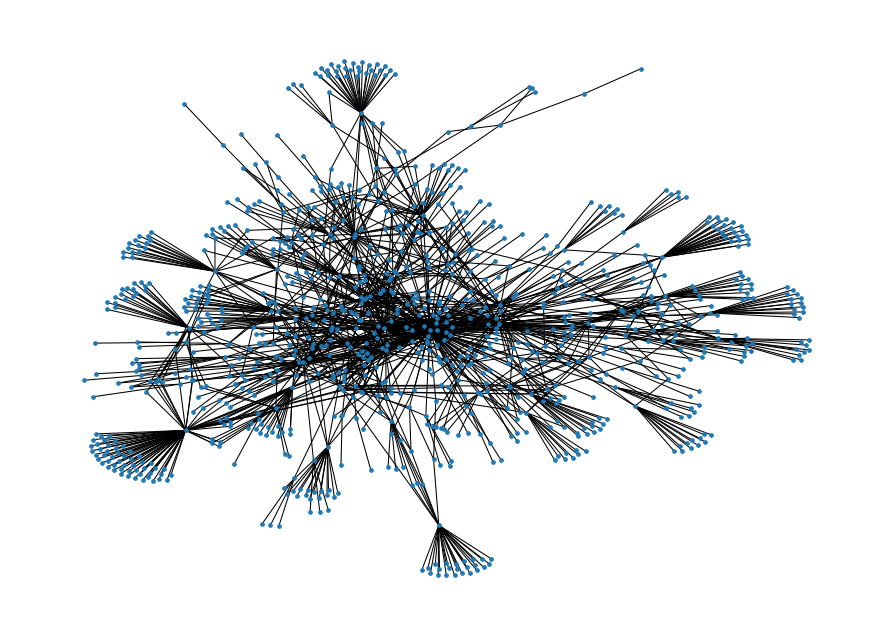

In [77]:
nx.draw(GCC, node_size=12)

In [78]:
# bipartite.write_edgelist(GCC, "/home/rob/MEGAsync/datasets/networks/bipartite_networks/unicodelang/country_lang_GCC.edge",
#                         data=False)
